In [1]:
print('https://www.whatismybrowser.com/detect/what-is-my-user-agent/')

https://www.whatismybrowser.com/detect/what-is-my-user-agent/


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os, sys
import shutil
import cv2

from tqdm.notebook import tqdm 
from google.colab import drive
from datetime import datetime
from pytz import timezone
from glob import glob 

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/collage')

# 구글 드라이브 내에 필요 패키지 설치를 위한 경로 설정 
try:
    os.mkdir('./packages')
except:
    print('-')
link_name = '/packages'
target = '/content/drive/My Drive/Colab Notebooks/collage/packages'
try:
  os.symlink(target, link_name)
except:
  os.chdir(target)
  os.remove(link_name)
  os.symlink(target, link_name)
sys.path.insert(0, link_name)

# 스크래핑에 필요한 헤더정보 정의
# 실행을 위해서는 각 환경에 맞는 유저에이전트 정보 필요 
headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-


In [3]:
## 필요 패키지 설치
# !pip --version
# !pip install --target=$link_name --upgrade pip
# !pip install --target=$link_name --use-deprecated=legacy-resolver git+https://github.com/kakaobrain/pororo.git
# !pip install --target=$link_name konlpy
# !pip install --target=$link_name python-mecab-ko
# !pip install --target=$link_name kollocate
# !pip install --target=$link_name koparadigm1
# !pip install --target=$link_name g2pk
# !pip install --target=$link_name selenium
# !pip install --target=$link_name webdriver_manager
# !pip install --target=$link_name cairosvg
# !pip install --target=$link_name Django
!pip install Django
## 셀레니움 스크래핑에 필요한 크롬 드라이버 설치 
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.n

In [4]:
# 설치한 자연어 처리모듈 뽀로로 및 직접정의한 py파일들 로드 / py파일에서 정의한 모든 주석은 각 py파일에 포함함
from pororo import Pororo

os.chdir('/content/drive/MyDrive/Colab Notebooks/collage')
import cairosvg 
import arrange
import scrap
import seg

# 자연어 처리 객체를 미리 생성
summ = Pororo(task="summarization", model="abstractive", lang="ko")
se = Pororo(task="sentence_embedding")
ner = Pororo(task="ner", lang="ko")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [5]:
# 산출물을 담을 딕셔너리 생성
def return_trend_dict():
  '''
  산출물을 담을 딕셔너리 생성 앞으로 return_dict라 칭할예정
  '''
  return {'keyword': None, 'namuKeyword': None, 'namuKeyword_kind': None, 'articles': None, 'links':None, 'title_picked':None, 'article_summary':None, 'img_name':None, 'img':None, 'img_coor':None}

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

In [7]:
# 시간 구분을 위함 
now = datetime.now(timezone('Asia/Seoul'))
datetime_text = str(now.strftime('%Y-%m-%d %H:%M'))

keyword_dicts = []
keyword_now = scrap.scrapSignalKeyword()

print(f'{datetime_text} : {keyword_now}')
for idx, keyword in tqdm(enumerate(keyword_now)):
  dict_ = return_trend_dict()
  articles, links = scrap.scrapNaverNewsKeyword(keyword, article_num=8, headers=headers, sort='1', length=350)
  # 원검색어
  dict_['keyword'] = keyword
  # 검색어에 대응하는 (제목, 내용)의 리스트
  dict_['articles'] = articles
  # 앞으로 이미지 파일을 저장할 파일 이름
  dict_['img_name'] = str(idx) + '.png'
  # 기사들에 대응하는 링크들
  dict_['links'] = links
  keyword_dicts.append(dict_)

2022-08-24 17:03 : ['전익수 부실 수사', '2024년 11월 14일', 'SRT', '이준석', '바닥판 균열 안전에는', '손흥민', '개량 백신 접종이', '선우은숙', '이재명', '정직한 후보 김무열']


0it [00:00, ?it/s]

In [8]:
# 한자어들 대체
def keyword_replace(txt):
  '''
  txt : str / 대체될 텍스트
  '''
  per_dict = { '尹':'윤석열', '文':'문재인', '與': '국민의힘', '野': '더불어민주당', }
  for word, replacement in per_dict.items():
    txt = txt.replace(word, replacement)
  return txt

In [9]:
def find_namukey(keyword, check_all=False, ):
  '''
  텍스트에서 ner이후 나무위키에서 사진을 가지고올 키워드들을 찾아내기 위한 함수
  인물을 우선적으로 추출

  keyword : 사진을 찾을 검색어를 찾으
  '''
  # 단어를 대체
  ner_result = ner(keyword_replace(keyword))
  ner_person_list = [re[0] for re in ner_result if re[1]=='PERSON']
  ner_or_list = [re[0] for re in ner_result if re[1]=='ORGANIZATION']
  ner_arti_list = [re[0] for re in ner_result if re[1]=='ARTIFACT']
  ner_city_list = [re[0] for re in ner_result if re[1]=='CITY']
  # 인물 키워드 뿐만 아니라 기관이나 도시같은 키워드도 반환
  if check_all:
    if len(ner_person_list) > 0:
      for p in ner_person_list:
        if keyword == p:
          return p, 'person'
      return ner_person_list[0], 'person'

    elif len(ner_or_list) > 0:
      for o in ner_or_list:
        if keyword == o:
          return o, 'organization'
      return ner_or_list[0], 'organization'

    elif len(ner_arti_list) > 0:
      for a in ner_arti_list:
        if keyword == a:
          return a, 'artifact'
      return ner_arti_list[0], 'artifact'

    elif len(ner_city_list) > 0:
      for c in ner_city_list:
        if keyword == c:
          return c, 'city'
      return ner_city_list[0], 'city'
    else :
      return keyword, '-'
  else:
    if len(ner_person_list) > 0:
      for p in ner_person_list:
        if keyword == p:
          return p, 'person'
      return ner_person_list[0], 'person'
    else :
      return keyword, '-'

In [10]:
# 각 검색어마다 나무위키에 검색할 키워드와 키워드의 종류를 할당
for dict_ in tqdm(keyword_dicts):
  dict_['namuKeyword'], dict_['namuKeyword_kind'] = find_namukey(dict_['keyword'])
  # dict_['namuKeyword'], dict_['namuKeyword_kind'] = '-', '-'

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
print([k['namuKeyword'] for k in keyword_dicts])

['전익수', '2024년 11월 14일', 'SRT', '이준석', '바닥판 균열 안전에는', '손흥민', '개량 백신 접종이', '선우은숙', '이재명', '김무열']


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def find_impor_title_idx(dict_):
  '''
  리턴 딕셔너리를 받아 해당 제목들의 cosine similarity를 구하여 스코어가 가장 높은 았던 제목의 인덱스를 반환하는 함수
  스코어가 가장 높은 제목이 현재의 이슈에 대한 내용을 담을 것이라는 가정하에 여러 기사들 사이에서 공통적인 내용을 의미하는 기사를 찾기 위함 

  dict_ : return_dict  
  '''

  titles = [keyword_replace(article[0].strip()) for article in dict_['articles']]
  titles_embedding = [se(t).reshape(1,-1) for t in titles]

  sims = []
  for i in range(len(titles_embedding)):
    cands = titles_embedding.copy()
    query = cands.pop(i)
    temp_num = 0
    for c in cands:
      temp_num += cosine_similarity(query, c)[0][0]
    sims.append(temp_num)
  max_ = max(sims)
  max_idx = sims.index(max_)

  return max_idx

In [13]:
def namukeyword_replace(txt):
  '''
  txt : str / 대체될 텍스트
  '''
  per_dict = { '검찰':'검찰청', '교직원공제회': '한국교직원공제회', '제주' : '제주특별자치도',  '경찰' : '대한민국 경찰청'}
  for word, replacement in per_dict.items():
    txt = txt.replace(word, replacement)
  return txt

In [14]:
for dict_ in tqdm(keyword_dicts):
  max_idx = find_impor_title_idx(dict_)
  dict_['title_picked'] = max_idx
  if dict_['namuKeyword_kind']=='-':
    # 적절한 검색키워드를 찾지 못한 경우 cosine_similarity가 가장 높았던 
    target_title = dict_['articles'][max_idx][0]
    dict_['namuKeyword'], dict_['namuKeyword_kind'] = find_namukey(target_title, check_all=True)
    dict_['namuKeyword'] = namukeyword_replace(dict_['namuKeyword'])


  dict_['article_summary'] = summ(dict_['articles'][max_idx][1],
                                  beam=5, 
                                  len_penalty=3,
                                  no_repeat_ngram_size=3,
                                  top_k=50,
                                  top_p=0.7,
                                  temperature=1.5
                                  )
  if dict_['namuKeyword_kind']=='-':
    target_content = dict_['article_summary']
    dict_['namuKeyword'], dict_['namuKeyword_kind'] = find_namukey(target_content, check_all=True)
    dict_['namuKeyword'] = namukeyword_replace(dict_['namuKeyword'])

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
print([k['namuKeyword'] for k in keyword_dicts])

['전익수', '한국교육과정평가원', '지제역 삼부르네상스', '이준석', '성산대교', '손흥민', '정부', '선우은숙', '이재명', '김무열']


In [16]:
try:
    os.mkdir('./result')
except:
    print('-')
os.chdir('/content/drive/MyDrive/Colab Notebooks/collage/result')
try:
    os.mkdir('./'+datetime_text)
except:
    pass
try:
    os.mkdir(f'./{datetime_text}/img')
    os.mkdir(f'./{datetime_text}/txt')
except:
    pass
# 각 검색어에 대응하는 나무위키검색키워드에 따라서 나무위키에서 이미지 크롤링 및 미리 스크래핑했던 기사들 파일로 저장
for i,dict_ in enumerate(keyword_dicts):
    print(f"{dict_['keyword']} -> {(dict_['namuKeyword'])}")
    try:
        os.mkdir(f"./{datetime_text}/txt/{dict_['keyword']}")
    except:
        pass
    txt_path = f"./{datetime_text}/txt/{dict_['keyword']}"
    scrap.saveArticles(dict_['articles'], txt_path)
    img_path = f'./{datetime_text}/img/{i}.png'
    scrap.scrapNamuImg(dict_['namuKeyword'],img_path, headers=headers, namuKeyword_kind=dict_['namuKeyword_kind'])

-
전익수 부실 수사 -> 전익수
https://w.namu.la/s/adf42fe7c5f1132c91c817193dfd731fffca171ec65957043584992a203c759f567e4daf88481ec904fd0c8091c5b6b391645913ab87ff2f80a0db69f6407dad4821c94c6ded1e77a7094b694a30179a20fce1c69977cbeffe23723a683b66be19b7a053fef44f0fa39c1b92a7ef16e6
2024년 11월 14일 -> 한국교육과정평가원
SRT -> 지제역 삼부르네상스
이준석 -> 이준석
https://w.namu.la/s/4a3e22276134054cb14c06c3ce535b9912274f4f6a3969e0f0606ebba62abc3cadee4553b2a0595ba10089b4fb7693a9856aac7014c4dfbbaa8acf8f13b150a648d2d8886f24452ac7352ce4e77eb1779f3d4b6345b69c575a626374af0a6030f1ec95553e6ae148a9815bb88d4bbef7
바닥판 균열 안전에는 -> 성산대교
손흥민 -> 손흥민
https://w.namu.la/s/1a40140b91e2ff9631c429e3968ffa65dc8a7ef1f40518c1c9ae814d973443eee4c339f5798b7bba3f422ec3bb9c6a71cfb42f7d116c16ee540ca0f57ae2fd65e34ceef9042231b7b1f71c825174ac8adc06a93b12a4ea0857d2e5ed8eee3275
개량 백신 접종이 -> 정부
선우은숙 -> 선우은숙
https://w.namu.la/s/28046ca316f3a1991c795c99b48fa92050eead5dae90d4c88cc07a8282a0eddf26a225447b822173d5f3bdcfffda4d9579692aadd550b8fae1ed1ab8dd0b041b3abe89f969ed8a

In [17]:
dict_ = keyword_dicts[-4].copy()

In [18]:
scrap.scrapNamuImg(dict_['namuKeyword'],img_path, headers=headers, namuKeyword_kind=dict_['namuKeyword_kind'])

In [19]:
try:
    os.mkdir('./'+datetime_text+'/segmentation')
except:
    print('-')
# 기학습한 모델 로드
model_present_path = '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/model_weight/DLv3+sgd0.01+unfreeze/sgd0.01.h5'
model_present = tf.keras.models.load_model(model_present_path)

In [20]:
face_detector = arrange.make_classifier('/content/drive/MyDrive/Colab Notebooks/collage/haarcascade_frontalface_alt.xml')

In [21]:
# 모델로 키워드가 사람인 경우에는 세그멘테이션 진행 이후 얼굴을 근처로 크롭
# 아닌 경우 (단체의 로고 따위) return_dict에만 저장
for dict_ in tqdm(keyword_dicts):
  load_path = f'./{datetime_text}/img/{dict_["img_name"]}'
  save_path = f'./{datetime_text}/segmentation/{load_path.split("/")[-1]}'
  if dict_['namuKeyword_kind'] == 'person':
    try:
      temp_img = seg.segSave(model_present, load_path, save_path=None)
      temp_img = arrange.crop_blank(temp_img)
      temp_img = arrange.crop_near_face(temp_img, face_detector)
      dict_['img'] = temp_img
      cv2.imwrite(save_path, temp_img)

    except:
      pass
  else:
    try:
      temp_img = cv2.imread(load_path, cv2.IMREAD_UNCHANGED)
      dict_['img'] = temp_img
    except:
      pass

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
# 이미지들에 흰테두리를 적용하고 배치좌표를 계산

img_list = [dict_['img'] for dict_ in keyword_dicts if dict_['img'] is not None]
img_names = [dict_['img_name'] for dict_ in keyword_dicts if dict_['img'] is not None]

image_resize = arrange.resize_after_crop(img_list)
image_resize_edge = [(seg.makeWhiteEdge(img, iterations=1)) for img in image_resize]
image_map = arrange.mapping_after_resize (image_resize_edge)
index = arrange.decision_position(image_map, more=True)
b_index = arrange.web_index(image_resize_edge, index)

In [23]:
# 각 이미지 좌표를 return_dict에 저장
coor = b_index.copy()
for dict_ in tqdm(keyword_dicts):
  if dict_['img'] is None:
    pass
  else:
    dict_['img_coor'] = coor.pop(0)

# 리사이즈, 엣지를 적용한 이미지들을 이미지파일로 저장
try:
    os.mkdir('./'+datetime_text+'/final_img')
except:
    print('-')

for name, img in zip(img_names, image_resize_edge):
  cv2.imwrite('./'+datetime_text+'/final_img/'+name, img)

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
# 지정한 기사의 이미지를 저장
try:
    os.mkdir('./'+datetime_text+'/article_img')
except:
    print('-')

for dict_ in tqdm(keyword_dicts):
  url = dict_['links'][dict_['title_picked']]
  scrap.save_article_img(url, headers, './'+datetime_text+'/article_img/'+dict_['img_name'])

  0%|          | 0/10 [00:00<?, ?it/s]

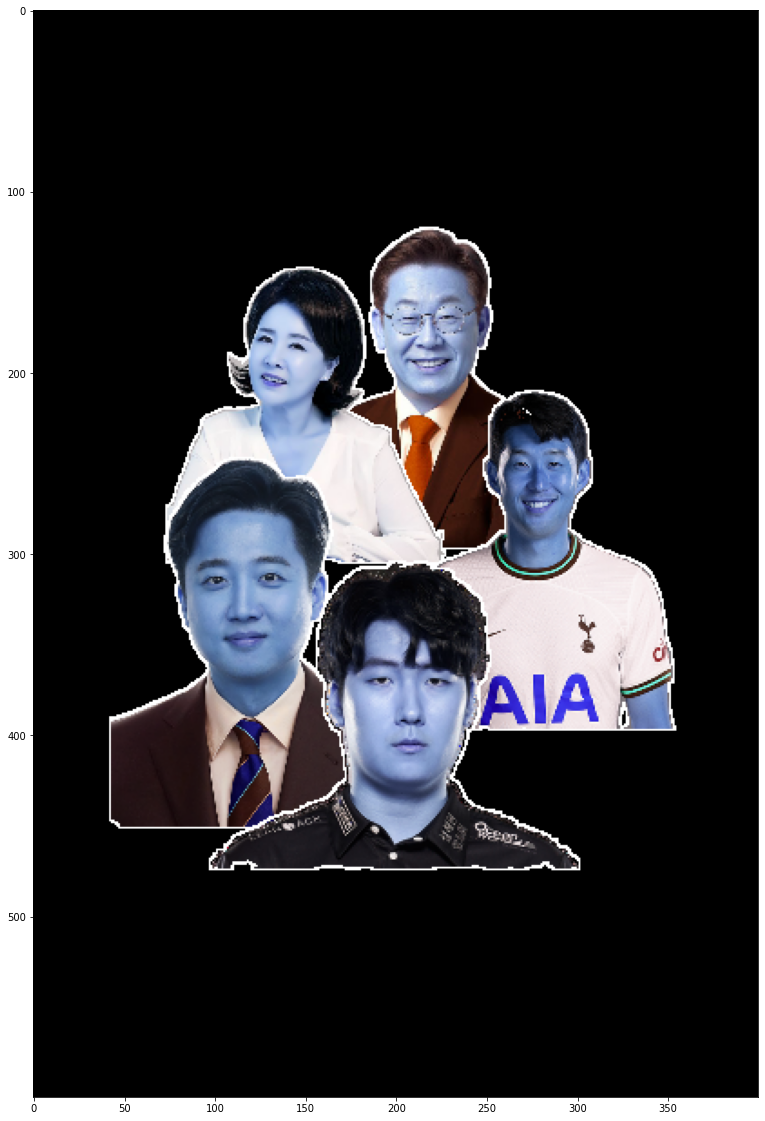

In [25]:
# 배치완료 이미지를 확인하기
background = np.zeros((600, 400, 3))
image_resize_edge.append(background)

after_padd = arrange.padding_position(image_resize_edge,index);
final_image, final_record = arrange.projection_image(after_padd)
cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/collage/result/{datetime_text}/final.png', final_image)
plt.figure(figsize=(20,20))
plt.imshow(final_image)

In [26]:
from distutils.dir_util import copy_tree

copy_tree(f'/content/drive/MyDrive/Colab Notebooks/collage/result/{datetime_text}/final_img', "/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/final_img")
copy_tree(f'/content/drive/MyDrive/Colab Notebooks/collage/result/{datetime_text}/article_img/', "/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/")

['/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/0.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/1.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/2.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/3.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/4.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/5.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/6.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/7.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/8.png',
 '/content/drive/MyDrive/Colab Notebooks/collage/django/collage/static/img/article_img/9.png']

In [27]:
import pandas as pd

def last_return(dict_):
  """
  마지막으로 웹에 적용할 최종리턴 값을 적용
  """
  last_return_dict = {
      'keyword' : dict_['keyword'],
      'article_link' : dict_['links'][dict_['title_picked']],
      'article_title' : dict_['articles'][dict_['title_picked']][0].strip(),
      'article_summary' : dict_['article_summary'],
      'img' : f'../../../static/img/final_img/{dict_["img_name"]}',
      'img_x' : dict_['img_coor'][0],
      'img_y' : dict_['img_coor'][1],
      'img_article' : f'../../../static/img/article_img/{dict_["img_name"]}',
      'time' : datetime_text
  }
  return last_return_dict
# 웹에 리턴할 csv생성
ret_csv = pd.DataFrame()
for kd in [last_return(dict_) for dict_ in keyword_dicts 
           if dict_['img_coor'] is not None
           ]:
  ret_csv = ret_csv.append(kd, ignore_index=True)

display(ret_csv)
ret_csv.to_csv('/content/drive/MyDrive/Colab Notebooks/collage/django/collage/collageapp/csv/collage.csv', index=False)

,keyword,article_link,article_title,article_summary,img,img_x,img_y,img_article,time
0,전익수 부실 수사,https://n.news.naver.com/mnews/article/081/000...,"이예람 특검, 전익수 공군 법무실장 피의자 신분 소환조사",훈련팀은 지난 12일 군인권센터가 성폭력 가해자에 대한 불구속 수사를 지휘한 정황이...,../../../static/img/final_img/0.png,97.0,304.0,../../../static/img/article_img/0.png,2022-08-24 17:03
1,이준석,https://n.news.naver.com/mnews/article/022/000...,"이준석, 자필탄원서 당내 비판에 “오매불망 체리따봉이나 기다리시길”",이준석 전 국민의힘 대표는 전날 자신이 법원에 제출한 당 비대위 효력정지 가처분 신...,../../../static/img/final_img/3.png,43.0,247.0,../../../static/img/article_img/3.png,2022-08-24 17:03
2,손흥민,https://sports.news.naver.com/news.nhn?oid=450...,"[st&현장] '월드컵 한국 최다골' 박지성 ""손흥민이 내 기록 깼으면""",코 코카콜라가 진행하는 이번 트로피 투어는 '2022 FIFA 카타르 월드컵' 성공...,../../../static/img/final_img/5.png,204.0,211.0,../../../static/img/article_img/5.png,2022-08-24 17:03
3,선우은숙,https://n.news.naver.com/mnews/article/312/000...,"[종합] 장나라, ♥6살 연하 남편 최초 공개…박원숙 ""너무 잘생겼다"" 감탄 ('같...",KBS 방송된 KBS2 예능 ‘박원숙의 같이 삽시다' 에서는 게스트 선우은숙이 신혼...,../../../static/img/final_img/7.png,72.0,143.0,../../../static/img/article_img/7.png,2022-08-24 17:03
4,이재명,https://n.news.naver.com/mnews/article/214/000...,경기남부경찰청 '법인카드 의혹' 배 모 씨 사전구속영장 신청,경찰이명 김 씨의 수행비서 역할을 했던 전직 경기도 5급 공무원 배모 씨가 이재명 ...,../../../static/img/final_img/8.png,155.0,121.0,../../../static/img/article_img/8.png,2022-08-24 17:03


In [28]:
ret_csv['img_article'][0]

'../../../static/img/article_img/0.png'

In [30]:
ret_csv['img_article'][0]

'../../../static/img/article_img/0.png'

In [31]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/collage/django/collage')
from google.colab.output import eval_js

In [34]:
print(eval_js("google.colab.kernel.proxyPort(8000)"))

https://mznay7lbuqe-496ff2e9c6d22116-8000-colab.googleusercontent.com/


In [35]:
!python manage.py runserver 8000

Watching for file changes with StatReloader
Performing system checks...

System check identified no issues (0 silenced).
August 24, 2022 - 08:08:09
Django version 3.2.15, using settings 'collage.settings'
Starting development server at http://127.0.0.1:8000/
Quit the server with CONTROL-C.
[24/Aug/2022 08:08:10] "GET / HTTP/1.1" 200 10175
[24/Aug/2022 08:08:10] "GET /static/css/1.css HTTP/1.1" 200 3072
[24/Aug/2022 08:08:10] "GET /static/img/final_img/0.png HTTP/1.1" 200 42538
[24/Aug/2022 08:08:10] "GET /static/img/final_img/3.png HTTP/1.1" 200 46518
[24/Aug/2022 08:08:10] "GET /static/img/final_img/5.png HTTP/1.1" 200 46348
[24/Aug/2022 08:08:10] "GET /static/img/final_img/7.png HTTP/1.1" 200 34827
[24/Aug/2022 08:08:10] "GET /static/img/final_img/8.png HTTP/1.1" 200 35831
Not Found: /favicon.ico
[24/Aug/2022 08:08:11] "GET /favicon.ico HTTP/1.1" 404 2236
[24/Aug/2022 08:08:16] "GET / HTTP/1.1" 200 10175
[24/Aug/2022 08:08:17] "GET /static/css/1.css HTTP/1.1" 200 3072
[24/Aug/2022 08

In [ ]:
def set_chrome_driver(headers):
    '''
    크롤링을 위한 셀레니움 브라우저를 생성하는 함수

    headers : dict / 유저 에이전트 정보가 담겨있는 딕셔너리
    '''
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("user-agent="+headers["user-agent"])
    driver = webdriver.Chrome('chromedriver', options=chrome_options)
    return driver

def check_txt_logo(txt, in_=True):
    '''
    문자열에 로고에 해당하는 키워드가 있는지 검사하는 코드

    txt : str / 키워드 체크를 진행할 문자열
    in_ : bool / True -> 키워드가 한개라도 있는지 체크 False -> 키워드가 하나도 없는지 체크
    '''
    # 소문자를 모두 대문자로 통일
    txt = txt.upper()
    if in_:
        return '로고' in  txt or 'LOGO' in  txt or 'CI' in  txt or '휘장' in txt
    else:
        return '로고' not in txt and 'LOGO' not in  txt and 'CI' not in  txt and '휘장' not in txt


def scrapNamuImg(key, path, headers,namuKeyword_kind='person'):
    '''
    원하는 키워드를 활용하여 나무위키에서 원하는 이미지를 스크랩하는 함수

    key : str / 나무위키에 검색할 키워드
    path : str / 스크랩한 이미지가 저장될 위치
    headers : dict / 유저 에이전트 정보가 담겨있는 딕셔너리
    namuKeyword_kind : str / 검색하는 key의 종류 
    '''

    driver = set_chrome_driver(headers)
    url = 'https://namu.wiki/w/'+key
    driver.get(url=url)
    html = driver.page_source
    driver.close()
    soup = BeautifulSoup(html, 'lxml')

    if namuKeyword_kind == 'person':
        # 이미지 이름에 로고에 해당하는 키워드가 들어가 있지 않는 이미지링크들
        imglink = [il['src'] for il in soup.find_all('img', attrs={'class':'_80UxW8aw'}) if not il.find_parent('dd') and check_txt_logo(il['alt'], in_=False) ]
        for i, link in enumerate(imglink):
            # 각 이미지 링크에 접근
            res=requests.get("https:"+link,headers=headers)
            # 웹에서 사용하는 svg나 video 형식은 가지고 오지 않도록 
            if 'svg' not in res.text and 'video' not in res.text:
                urlopen_img = Image.open(BytesIO(res.content))
                # counts = np.unique(np.array(urlopen_img.split()[-1]), return_counts=True)[1]
                # ratio = counts[0]/np.sum(counts)
                # 원본이미지의 화소가 기준치를 넘을 시에만 
                if urlopen_img.size[1]*urlopen_img.size[0] > 100000 :
                    print(res.url)
                    if path:
                        urlopen_img.save(path,'png')
                    break
    else :
        # 보정된 검색어를 가지고오고 소문자를 대문자로 통일
        key_ = soup.find('title').text.replace(' - 나무위키','').upper()
        # 키워드와 로고키워드가 있을 시에
        imglink = [il['src'] for il in soup.find_all('img', attrs={'class':'dVTtICxy'}) if not il.find_parent('dd') and (key_ in  il['alt']) and check_txt_logo(il['alt']) ]
        if len(imglink) < 1:
            #로고키워드가 있을 시에
            imglink = [il['src'] for il in soup.find_all('img', attrs={'class':'dVTtICxy'}) if not il.find_parent('dd') and check_txt_logo(il['alt'])]
        for i, link in enumerate(imglink):
            res=requests.get("https:"+link,headers=headers)
            try:
                # svg형식의 경우 처리를 하여 가지고옴
                urlopen_img = Image.open(BytesIO(cairosvg.svg2png(res.content)))
                print(res.url)
                if path:
                    urlopen_img.save(path,'png')
                break
            except:
                urlopen_img = Image.open(BytesIO(res.content))
                print(res.url)
                if path:
                    urlopen_img.save(path,'png')
                break

In [ ]:
key = '우리은행'
namuKeyword_kind = 'r'

In [ ]:
driver = set_chrome_driver(headers)
url = 'https://namu.wiki/w/'+key
driver.get(url=url)
html = driver.page_source
driver.close()
soup = BeautifulSoup(html, 'lxml')

if namuKeyword_kind == 'person':
    # 이미지 이름에 로고에 해당하는 키워드가 들어가 있지 않는 이미지링크들
    imglink = [il['src'] for il in soup.find_all('img', attrs={'class':'_80UxW8aw'}) if not il.find_parent('dd') and check_txt_logo(il['alt'], in_=False) ]
    for i, link in enumerate(imglink):
        # 각 이미지 링크에 접근
        res=requests.get("https:"+link,headers=headers)
        # 웹에서 사용하는 svg나 video 형식은 가지고 오지 않도록 
        if 'svg' not in res.text and 'video' not in res.text:
            urlopen_img = Image.open(BytesIO(res.content))
            # counts = np.unique(np.array(urlopen_img.split()[-1]), return_counts=True)[1]
            # ratio = counts[0]/np.sum(counts)
            # 원본이미지의 화소가 기준치를 넘을 시에만 
            if urlopen_img.size[1]*urlopen_img.size[0] > 100000 :
                print(res.url)
                if path:
                    urlopen_img.save(path,'png')
                break
else :
    # 보정된 검색어를 가지고오고 소문자를 대문자로 통일
    key_ = soup.find('title').text.replace(' - 나무위키','').upper()
    # 키워드와 로고키워드가 있을 시에
    imglink = [il['src'] for il in soup.find_all('img', attrs={'class':'_80UxW8aw'}) if not il.find_parent('dd') and (key_ in  il['alt']) and check_txt_logo(il['alt']) ]
    if len(imglink) < 1:
        #로고키워드가 있을 시에
        imglink = [il['src'] for il in soup.find_all('img', attrs={'class':'_80UxW8aw'}) if not il.find_parent('dd') and check_txt_logo(il['alt'])]
    for i, link in enumerate(imglink):
        res=requests.get("https:"+link,headers=headers)
        try:
            # svg형식의 경우 처리를 하여 가지고옴
            urlopen_img = Image.open(BytesIO(cairosvg.svg2png(res.content)))
            print(res.url)
            if path:
                urlopen_img.save(path,'png')
            break
        except:
            urlopen_img = Image.open(BytesIO(res.content))
            print(res.url)
            if path:
                urlopen_img.save(path,'png')
            break

In [ ]:
soup